# 🌟 Assignment 2. Operation "AI GeoGuessr"

### Deadline: Friday, October 24, 2025, 11:59:00 PM CET (GMT +2)

## 🎯 Mission Overview

The operation consists of two independent missions. Similar to the previous operation, students are required to solve the tasks by achieving the required score and answering the follow-up questions.

## 🧪 Neural Networks and Unsupervised Learning

1. **Mission 2.1 (Supervised Learning)**: 
   - Solve a supervised learning problem using a multilayer perceptron (MLP).

2. **Mission 2.2 (Unsupervised Learning)**:
   - Given an unlabeled dataset, your task is to cluster similar data points and achieve 100% clustering accuracy. You will not have access to the true labels, but you can verify your cluster assignments using the Kaggle competition provided.

## 📝 Delivery Format (Blackboard)

Please submit **two files**:
1. The completed Jupyter notebook.
2. The solution for the second dataset as a CSV file with two `int` columns: `['ID', 'cluster']`.

## Kaggle details
- Invitation link: https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc
- Kaggle is a popular platform for data science competitions.
- It allows us to create a Private competition where you can submit your solutions and verify whether you are thinking in the right direction.
- The results of the competition is visible only to the competition participants. 
- We will not grade the submissions on Kaggle, we set it up to let you check your clustering.
- You still have to deliver the `.csv` file of the solution and the complete `.ipynb` notebook with discussions and solution code.  

> Good luck, comrade!

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 🧠 Mission 2.1: Decoding SkyNet's Neural Encryption **(using Neural Networks)**

### 🌐 The Discovery
The dataset consists of the same "Synapse Cipher" data from Assignment 1.

### 🎯 Your Mission
1. Implement a multilayer perceptron (MLP) using one of the following frameworks: Keras, PyTorch, or TensorFlow.
2. Solve the non-linear problem without manual feature engineering.
3. Predict SkyNet's binary decisions (0 or 1) based on paired signals.
4. Improve performance by using techniques such as learning rate scheduling, selecting a good optimizer, and fine-tuning hyperparameters.

> Note: There are no restrictions on the tricks you can use — Have fun :) 

### 📊 Formal Requirements
1. **Implementation**:
   - Develop a Neural Network using predefined functions/layers.
   - Use one of the popular frameworks: Keras, PyTorch, or TensorFlow.
   - Implement a manual learning rate scheduler with warmup and cosine decay.

2. **Performance**: Achieve at least **0.92** accuracy on the test set.

3. **Discussion**:
   - How can you make sure the results are reproduable?
   - Visualize the network's architecture and decision boundary.
   - Which optimizer did you choose? Discuss the differences between SGD and Adam.
   - Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?
   - Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

In [ ]:
data = pd.read_csv('nn_data.csv')
train = data[data['split'] == 'train']
test = data[data['split'] == 'test']

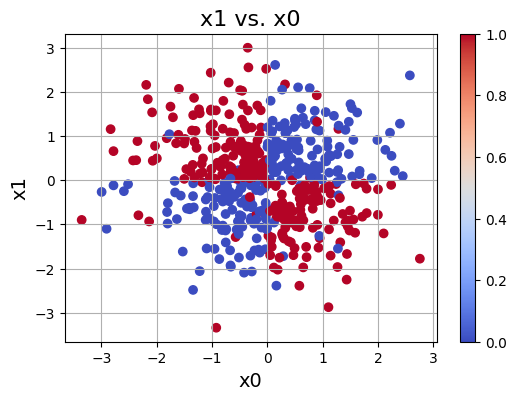

In [ ]:
plt.figure(figsize=(6, 4))
plt.scatter(train['x0'], train['x1'], c=train['y'], cmap='coolwarm')
plt.grid(True)
plt.xlabel('x0', fontsize=14)
plt.ylabel('x1', fontsize=14)
plt.title('x1 vs. x0', fontsize=16)
plt.colorbar()
plt.show()

Importerer biblioteker

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler 

Forberede dataen

In [ ]:
#skalerer dataen med forventningsverdi 0 og standardavvik 1
scaler = StandardScaler()
X_train = scaler.fit_transform(train[['x0', 'x1']]) 
X_test = scaler.transform(test[['x0', 'x1']]) 

#Gjør om dataen til PyTorch tensorer for å kunne bruke dem i et nevralt nettverk
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.FloatTensor(train['y'].values)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.FloatTensor(test['y'].values)

#lage klasser for datasett og dataloader
class CustomDataset(Dataset):
    def __init__(self, X, y): #initialiserer datasettet med variabler
        self.X = X
        self.y = y

    def __len__(self): #returnerer lengden på datasettet
        return len(self.y)

    def __getitem__(self, idx): #akkseserer elementer i datasettet ved index
        return self.X[idx], self.y[idx]

#Lager trenings datasett
train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True) #64 om gangen og shuffle for randomness

#Lager test datasettet
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64) 


Konstruere neurale nettverket

In [ ]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(2, 32),           # Wider first layer
            nn.BatchNorm1d(32),
            nn.ReLU(),
            
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            
            nn.Linear(16, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)
model = MLP()
criterion = nn.BCELoss() #Binary Cross Entropy Loss
optimizer = torch.optim.Adam(
    model.parameters(), 
    lr=0.001,              # Learning rate
    weight_decay=1e-5,     # L2 penalty
) #adaptive moment estimation

Create learning rate schedular

In [ ]:
def get_lr(epoch, num_epochs, base_lr=1.0, warmup_fraction=0.2, min_lr_factor=0.1):
    warmup_epochs = int(num_epochs * warmup_fraction)
    min_lr = base_lr * min_lr_factor

    if epoch < warmup_epochs:
        # More gradual warmup
        return min_lr + (base_lr - min_lr) * epoch / warmup_epochs
    else:
        # Gentler cosine decay with minimum learning rate
        current = epoch - warmup_epochs
        decay_epochs = num_epochs - warmup_epochs
        cosine_decay = 0.5 * (1 + np.cos(np.pi * current / decay_epochs))
        return min_lr + (base_lr - min_lr) * cosine_decay

Trener modellen

In [ ]:
num_epochs = 500
patience = 100  # Number of epochs to wait for improvement
min_delta = 0.001  # Minimum change in accuracy to qualify as improvement
learning_rates = []
train_losses = []
test_accuracies = []

best_accuracy = 0
no_improve = 0
best_weights = None

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    
    # Update learning rate
    current_lr = get_lr(epoch, num_epochs)
    for param_group in optimizer.param_groups:
        param_group['lr'] = current_lr
    learning_rates.append(current_lr)
    
    # Training phase
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        epoch_loss += loss.item()
    
    train_losses.append(epoch_loss / len(train_loader))
    
    # Testing phase
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X).view(-1)
            predicted = (outputs >= 0.5).float()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
            
    accuracy = correct / total
    test_accuracies.append(accuracy)
    
    # Early stopping and best model saving
    if accuracy >= 0.92:  # Stop if 0.92 is reached
        best_accuracy = accuracy
        best_weights = model.state_dict().copy()
        print(f"Target accuracy (0.92) reached at epoch {epoch} with accuracy: {best_accuracy:.4f}")
        model.load_state_dict(best_weights)
        break
    elif accuracy > best_accuracy + min_delta:
        best_accuracy = accuracy
        best_weights = model.state_dict().copy()
        no_improve = 0
        print(f"Epoch {epoch}: New best accuracy: {best_accuracy:.4f}")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"Early stopping triggered at epoch {epoch} due to no improvement")
            print(f"Best accuracy: {best_accuracy:.4f}")
            model.load_state_dict(best_weights)
            break
    
    if epoch % 50 == 0 or accuracy >= 0.92:
        print(f"Epoch [{epoch}/{num_epochs}], Loss: {train_losses[-1]:.4f}, "
              f"Accuracy: {accuracy:.4f}, LR: {current_lr:.6f}, No improvement: {no_improve}")

print(f"Training completed!")
print(f"Best accuracy achieved: {best_accuracy:.4f}")

Epoch 0: New best accuracy: 0.7940
Epoch [0/500], Loss: 0.5415, Accuracy: 0.7940, LR: 0.100000, No improvement: 0
Epoch 1: New best accuracy: 0.8360
Epoch 2: New best accuracy: 0.8740
Epoch 9: New best accuracy: 0.8760
Epoch 19: New best accuracy: 0.8780
Epoch 25: New best accuracy: 0.8840
Target accuracy (0.92) reached at epoch 27 with accuracy: 0.9240
Training completed!
Best accuracy achieved: 0.9240


Discussion:

How can you make sure the results are reproduable?

In [ ]:
#Ved å sette torch seed (og forsåvidt alle seeds) til et fast tall kan jeg forvente at resultatet er reproduserbart
torch.manual_seed(42)

Visualize the network's architecture and decision boundary.

/tmp/ipykernel_30522/3922574225.py:31: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(X_test_tensor[:,0].numpy(), X_test_tensor[:,1].numpy(),


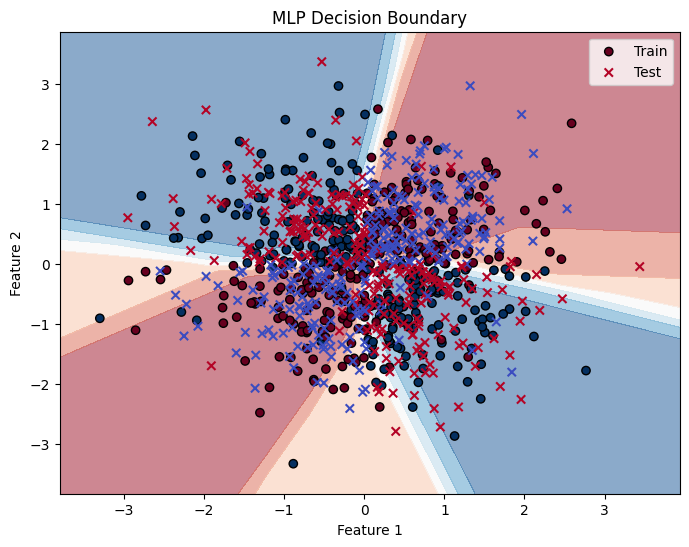

In [ ]:
model.eval()  # Set model to evaluation mode

# Extract all X values from the dataset to get min/max for plotting
X_all = torch.cat([X_train_tensor, X_test_tensor], dim=0).numpy()

x_min, x_max = X_all[:, 0].min() - 0.5, X_all[:, 0].max() + 0.5
y_min, y_max = X_all[:, 1].min() - 0.5, X_all[:, 1].max() + 0.5

xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))
grid = np.c_[xx.ravel(), yy.ravel()]

# Convert grid to torch tensor
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Get model predictions for the grid
with torch.no_grad():
    Z = model(grid_tensor).numpy()

Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.5, cmap=plt.cm.RdBu)

# Plot training points
plt.scatter(X_train_tensor[:,0].numpy(), X_train_tensor[:,1].numpy(), 
            c=y_train_tensor.numpy(), edgecolor='k', cmap=plt.cm.RdBu, label='Train')

# Plot testing points
plt.scatter(X_test_tensor[:,0].numpy(), X_test_tensor[:,1].numpy(), 
            c=y_test_tensor.numpy(), edgecolor='k', cmap=plt.cm.coolwarm, marker='x', label='Test')

plt.title("MLP Decision Boundary")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.legend()
plt.show()


Which optimizer did you choose? Discuss the differences between SGD and Adam.

I used Adam (Adaptive moment estimation) because of its fastness and how good it works out of the box. SGD is simpler but is most of the times slower.

Plot the learning rate curve. Did the learning rate scheduling improve performance? Why or why not?

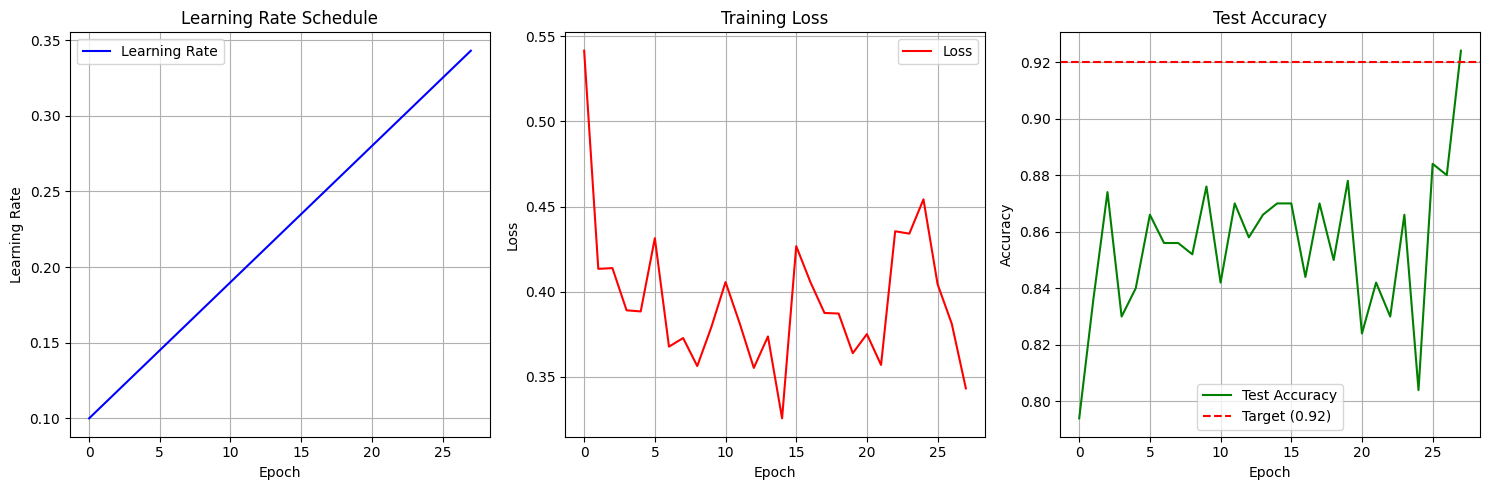

In [ ]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1) 
plt.plot(learning_rates, 'b-', label='Learning Rate') 
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 2) 
plt.plot(train_losses, 'r-', label='Loss') 
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 3, 3) 
plt.plot(test_accuracies, 'g-', label='Test Accuracy')
plt.axhline(y=0.92, color='r', linestyle='--', label='Target (0.92)')
plt.title('Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()
#My graph didnt converge when not applying early stoppage, therefore i added it. Learnign rate didnt help that much 

Conduct a simple ablation study of each architectural and optimization choice concerning test accuracy.

# 📶📡🛰️🤳 Mission 2.2: Locate the AI Servers

### 🌐 The Discovery
The NTNU Intelligence team has intercepted encrypted documentation that potentially reveals the locations of AI-compromised servers within Trondheim. Our analysts believe the data contains information about these servers' locations. 

However, the number of servers and their exact positions remain unknown. To execute a strategic response, we need to understand the intercepted data and pinpoint the main AI servers.

We have also discovered a vulnerability in the AI's security: it has deployed a clustering verification feature on Kaggle. We can exploit this backdoor to validate our clustering hypotheses.

### 🎯 Your Mission
Identify the number of hidden servers (clusters) in the dataset. Assign cluster labels to each row in the original dataset and validate your clustering solution on Kaggle.  When achieved the perfect clustering accuracy, find the precise locations of these servers (clusters).

### 🧠 The Challenge
1. **Large Dataset**: The intercepted data file contains numerous features, making direct manipulation and clustering difficult. Applying dimensionality reduction techniques could help reveal patterns.
2. **Unsupervised Learning**: No target labels are provided, so you must identify patterns based solely on the dataset's features.
3. **Data Obfuscation**: The AI has obfuscated the data, making it difficult to discern its true structure. You must effectively manipulate the data to visually identify server locations.


### 🚀 Your Tools
- The intercepted AI dataset.
- Skills in feature engineering, data manipulation, and visualization.
- Clustering algorithms (e.g., KMeans, DBSCAN, Birch, Agglomerative Clustering, etc.) — [Clustering in Scikit-Learn](https://scikit-learn.org/stable/modules/clustering.html)
- Dimensionality reduction techniques (e.g., PCA, t-SNE, Isomap, UMAP, etc.)
- Kaggle competition platform with a daily submission limit of 50 attempts.

> Note: Kaggle competition link — [Kaggle Competition](https://www.kaggle.com/t/dfb72837bdb346449768b8f6ce50b6dc)

### 📊 Formal Requirements
1. **Achieve 100% Clustering Accuracy** on Kaggle.
> Note: The only way to check whether your clustering is correct is to submit it to Kaggle. We do not give you the clusters directly.

2. **Discussion Questions**:
   - **Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.
   - **Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
   - **Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?
   - **Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.
   - **Advanced Task (Optional)**: Extract features using modern pre-trained neural networks for this data type. Apply dimensionality reduction and clustering algorithms to the extracted features.

In [70]:
# Hmmmmm, why is the first row skipped?
data = pd.read_csv('unsupervised_data.csv', skiprows=1, header=None)
# Get the ID column
data.reset_index(drop=False, inplace=True)
data.rename(columns={'index': 'ID'}, inplace=True)
data

,ID,0,1,2,3,4,5,6,7,8,...,16374,16375,16376,16377,16378,16379,16380,16381,16382,16383
0,0,0.314365,0.646305,0.323849,0.238492,0.655790,0.646305,0.646305,0.409205,0.646305,...,0.646305,0.646305,0.655790,0.238492,0.646305,0.674758,0.646305,0.238492,0.655790,0.646305
1,1,0.587628,0.494976,0.559832,-0.246237,0.513506,0.550567,0.522772,0.596893,0.606158,...,0.587628,0.550567,0.587628,0.587628,0.550567,0.587628,0.550567,0.596893,0.494976,0.587628
2,2,0.590203,0.367673,0.367673,0.367673,0.367673,0.590203,0.367673,0.590203,0.590203,...,0.590203,0.367673,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.590203,0.476556
3,3,0.589296,0.589296,0.579825,0.551415,0.579825,0.579825,0.608236,0.579825,0.646118,...,0.532474,0.523003,0.589296,0.589296,0.551415,0.134721,0.475652,0.589296,0.570355,0.551415
4,4,0.660095,0.470676,0.190366,0.672806,0.470761,0.672766,0.672652,0.666151,0.672987,...,0.432001,0.672222,0.190568,0.217329,0.633684,0.673294,0.587914,0.671023,0.207578,0.470765
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3995,3995,0.340739,0.340739,0.340739,0.681823,0.340739,0.340739,0.340739,0.672083,0.340739,...,0.340739,0.662355,0.340739,0.759779,0.331011,0.759779,0.340739,0.691563,0.340734,0.720789
3996,3996,0.384257,0.384257,0.675221,0.384257,0.384257,0.675221,0.384257,0.675221,0.675221,...,0.675221,0.384257,0.675221,0.675221,0.675221,0.384257,0.384257,0.384257,0.675221,0.675221
3997,3997,0.641837,0.651135,0.251329,0.251329,0.651135,0.651135,0.251329,0.651135,0.651135,...,0.251329,0.251329,0.651135,0.251329,0.409392,0.604646,0.651135,0.651135,0.660433,0.251329
3998,3998,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,-0.212897,0.555533,...,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533,0.555533


In [71]:
# The dataset is heavy. Applying clustering directly on the dataset is likely not feasible. 
data.info(0)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Columns: 16385 entries, ID to 16383
dtypes: float64(16384), int64(1)
memory usage: 500.0 MB


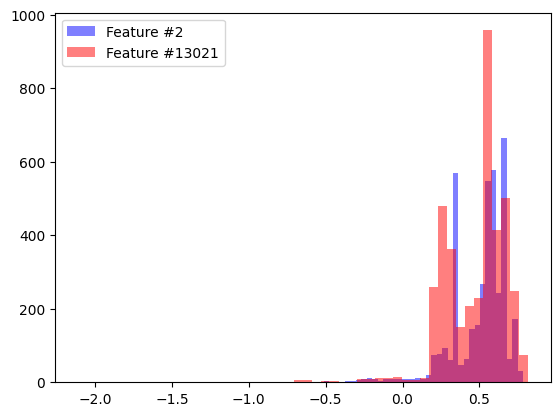

In [72]:
# Features seem to be similarly distributed...
plt.hist(data.iloc[:, 2], bins=50, color='blue', alpha=0.5, label='Feature #2')
plt.hist(data.iloc[:, 13021], bins=50, color='red', alpha=0.5, label='Feature #13021')
plt.legend()
plt.show()

/home/henrik/TDT4172/.venv/lib/python3.12/site-packages/sklearn/manifold/_isomap.py:384: UserWarning: The number of connected components of the neighbors graph is 11 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/home/henrik/TDT4172/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/henrik/TDT4172/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])
/home/henrik/TDT4172/.venv/lib/python3.12/site-packages/scipy/sparse/_index.py:168: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._s

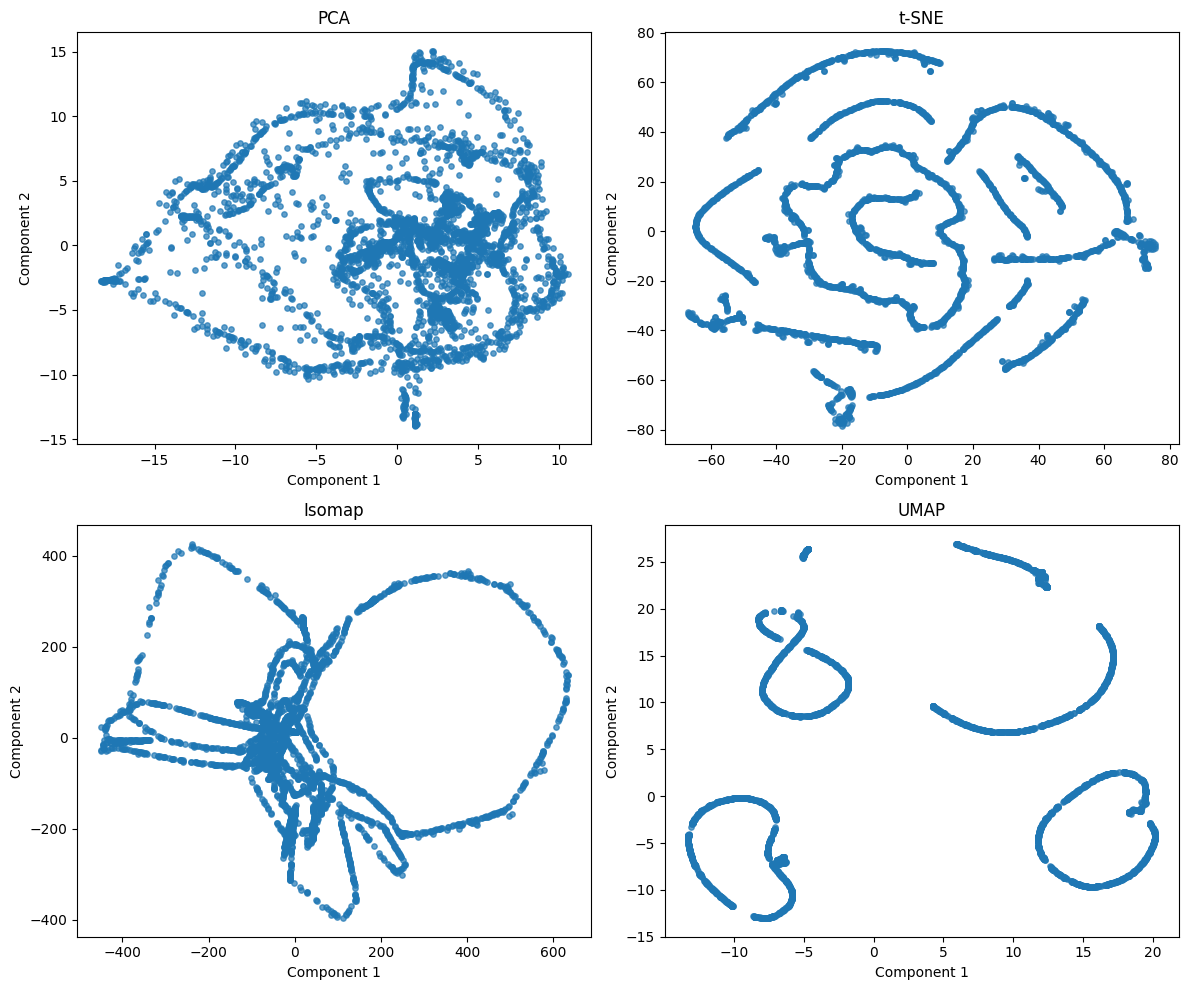

In [73]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, Isomap
import umap.umap_ as umap

X = data.drop(columns=['ID']).values


# Dimensionality reduction to 2D
X_pca = PCA(n_components=2).fit_transform(X)
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(X)
X_isomap = Isomap(n_components=2).fit_transform(X)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap = umap_model.fit_transform(X)

# --- Plot in 2D ---
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
methods = ['PCA', 't-SNE', 'Isomap', 'UMAP']
datasets = [X_pca, X_tsne, X_isomap, X_umap]

for ax, name, data_2d in zip(axes.flatten(), methods, datasets):
    ax.scatter(data_2d[:, 0], data_2d[:, 1], s=15, alpha=0.7)
    ax.set_title(name)
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')

plt.tight_layout()
plt.show()


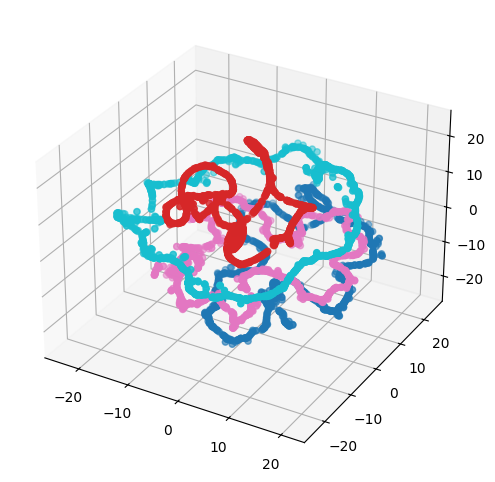

In [74]:
from sklearn.cluster import DBSCAN

#Chosen dimensionality reduction method
X_tsne = TSNE(n_components=3, random_state=42).fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=5, min_samples=8)  # Manually fixed eps
labels = dbscan.fit_predict(X_tsne)

# 3D plot
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection="3d")
scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c=labels, cmap='tab10')
plt.show()

# Save cluster labels
pred_df = pd.DataFrame({
    "ID": data['ID'],  # original ID column
    "cluster": labels
})
pred_df.to_csv("submission.csv", index=False)

/tmp/ipykernel_7729/2957795576.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', len(unique_labels))


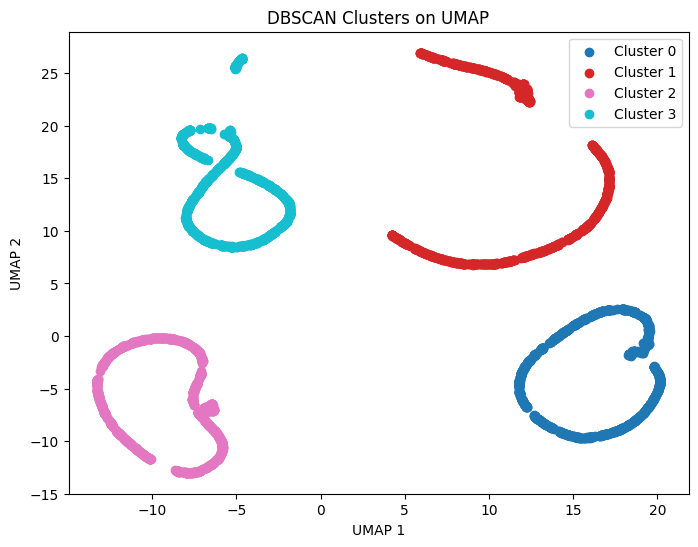

In [75]:
# --- Apply DBSCAN on UMAP 2D data ---
dbscan = DBSCAN(eps=6, min_samples=12)  # You can tune eps and min_samples
clusters = dbscan.fit_predict(X_umap)  # cluster labels (-1 means noise)

# --- Plot UMAP with DBSCAN clusters ---
plt.figure(figsize=(8, 6))
unique_labels = np.unique(clusters)
colors = plt.cm.get_cmap('tab10', len(unique_labels))

for label in unique_labels:
    mask = clusters == label
    if label == -1:
        # Noise points
        plt.scatter(X_umap[mask, 0], X_umap[mask, 1],  color='k', alpha=0.5, label='Noise')
    else:
        plt.scatter(X_umap[mask, 0], X_umap[mask, 1], color=colors(label), label=f'Cluster {label}')

plt.title('DBSCAN Clusters on UMAP')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.legend()
plt.show()

Both UMAP in 2d and t-SNE in 3d combined with DBscan could be tuned to 4 clusters, suggesting a 3 cluster is right.

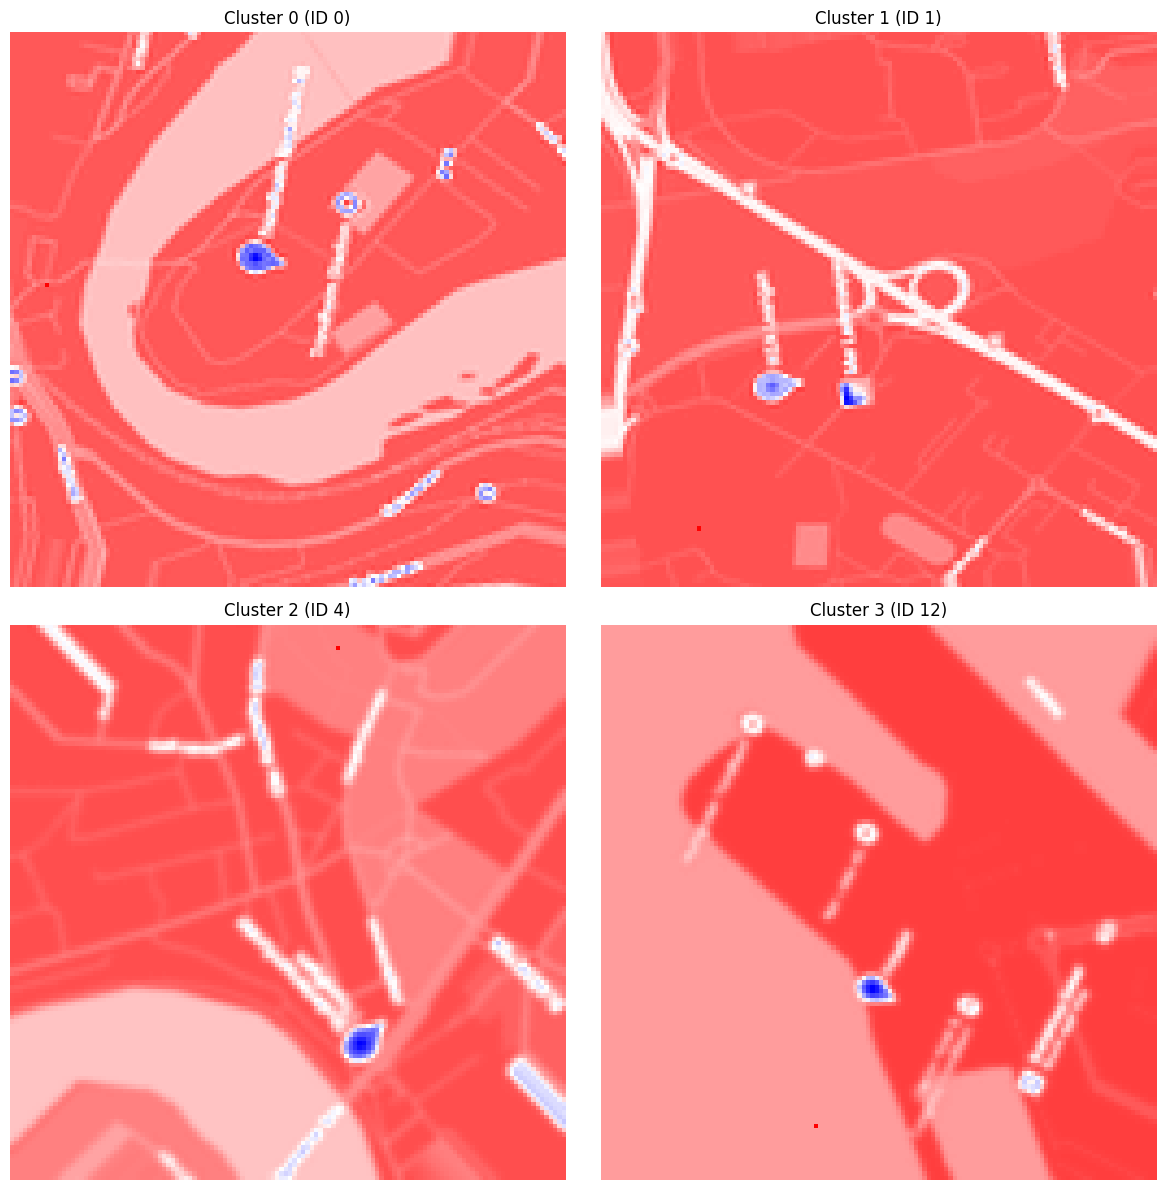

In [76]:
# Load data
df = pd.read_csv('unsupervised_data.csv')

# Extract and sort numeric columns (skip ID)
cols = df.columns[:] 
col_indices = np.array([int(c[4:]) for c in cols])  # numeric indices
sorted_cols = cols[np.argsort(col_indices)]  # reorder columns numerically

# IDs of the first 4 clusters
cluster_ids = [0, 1, 4, 12]  # replace with your known IDs

# Plot images for each cluster
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes = axes.ravel()


for i, cluster_id in enumerate(cluster_ids):
    row_array = df[sorted_cols].iloc[cluster_id].to_numpy()
    image = row_array.reshape(128, 128)
    axes[i].imshow(image, cmap='bwr')
    axes[i].set_title(f'Cluster {i} (ID {cluster_id})')
    axes[i].axis('off')

plt.tight_layout()
plt.show()


In [77]:
# To check your clustering, you need to assign the predicted cluster ids and submit it as a CSV file. The submission should be a CSV file with two columns: ID and cluster. 
# The ID column should contain the ID of the data point, and the cluster column should contain the cluster ID that the data point belongs to. 
# The cluster ID should be an integer. Current cluster IDs in sample_submission.csv are randomly generated.
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,ID,cluster
0,0,2
1,1,6
2,2,3
3,3,3
4,4,8
...,...,...
3995,3995,3
3996,3996,7
3997,3997,3
3998,3998,7


**Dimensionality Reduction**: Which dimensionality reduction methods helped you determine the correct number of clusters? Why did some methods work better than others? Explain the differences between PCA, t-SNE, and UMAP.

- **PCA:** A linear method that reduces dimensionality by projecting data onto directions of maximum variance.  
- **t-SNE:** A nonlinear method that preserves local neighborhood structure for visualization in 2D/3D.  
- **UMAP:** A nonlinear method that preserves local and some global structure, faster than t-SNE and good for clustering and visualization.

- I used a 3d t-SNE to predict clusters and tweaked a umap to confirm

- PCA made 4 lines -> could be 4 clusters. But wasnt sure. t-SNE in 2d was rubbish but when i tweaked it in 3d to make 4 clusters it made sense, tested it on kaggle.


**Clustering Approach**: Which clustering algorithm and hyperparameters did you use? Discuss the differences between algorithms like KMeans and DBSCAN.
- I usd DB-scan since it doesnt need to know how many clusters i need beforehand
- **K-Means:** Partitions data into a fixed number of clusters (`k`) by minimizing within-cluster variance, assuming roughly spherical clusters.  
- **DBSCAN:** Groups points based on density, identifying clusters of arbitrary shape and labeling low-density points as noise, without needing to specify the number of clusters.


**Data Type Analysis**: What is the hidden data type in the dataset? How does this information influence feature extraction for clustering? Can it explain why some dimensionality reduction algorithms are more effective?

In [78]:
df = pd.read_csv('unsupervised_data.csv')
df.iloc[0]

KeyboardInterrupt: 

- The hidden datatype is photos of the 4 locations. Some of the ID's had worse image such as ID 6 of cluster 3 - Couldnt see the sea. The photo is stored in a randomized order for each row and tehrefore needs sorting.
- PCA assumes linear combinations of features and therefore sucks
- t-SNE and umap preserves local neighborhoods - Better for this task

**Server Locations**: Identify the server locations. List the specific facilities in Trondheim and explain how you deduced their locations.

- Øya, Ikea leangen, Samfundet and pirbadet.
- deduced their location by sorting the row based on col number in a 128x128 format. then plotted one of each cluster. This gave me the photo as above.


---

## 🎯 Note: Clustering Accuracy Evaluation

The clustering accuracy metric evaluates how well the predicted clusters match the true clusters, irrespective of the specific labels or names assigned to the clusters.

This means that the evaluation is solely based on the correct grouping of data points rather than the numerical labels of the clusters themselves.

## Key Characteristics

- **Name-Independent**: The metric cares only about how well the data points are grouped together, not the specific numerical or categorical labels used for the clusters.
- **Focus on Grouping**: The evaluation rewards cluster assignments that correctly group the same data points together, regardless of the specific labels assigned.

### Example

If the true cluster assignments are:

```
[0, 0, 0, 1, 1, 1]
```

and your predicted cluster assignments are:

```
[1, 1, 1, 0, 0, 0]
```

the accuracy will still be **1.0** because the grouping of points is identical, even though the numerical labels are swapped.

## How the Metric is Computed

1. **Contingency Matrix**: 
   - Construct a contingency matrix that represents the overlap between the true clusters and the predicted clusters.

2. **Optimal Correspondence**: 
   - Use an optimization algorithm, such as the Hungarian method (linear sum assignment), to find the best possible correspondence between true and predicted labels, maximizing the number of correctly assigned data points.

3. **Accuracy Calculation**: 
   - Calculate the accuracy as the ratio of correctly matched data points to the total number of data points.

> This approach ensures that the evaluation is based on **cluster completeness** and **homogeneity**, rewarding cluster assignments that correctly group the same data points together, regardless of the specific labels used.

---

In [ ]:
import numpy as np
import scipy.optimize
import sklearn.metrics

def calculate_clustering_accuracy(true_labels: np.ndarray, cluster_labels: np.ndarray) -> float:
    """
    Calculate the clustering accuracy between true labels and cluster labels.

    The function constructs a contingency matrix between the true labels and cluster labels.
    It then uses the Hungarian algorithm (also known as linear sum assignment) to find the
    best matching between the cluster labels and true labels. The clustering accuracy is 
    calculated as the number of correctly matched labels divided by the total number of labels.

    Args:
        true_labels (np.ndarray): An array of true labels for each data point.
        cluster_labels (np.ndarray): An array of cluster labels predicted by a clustering algorithm.

    Returns:
        float: The clustering accuracy, a value between 0 and 1 representing the proportion of 
               correctly matched labels.
    
    Example:
        >>> true_labels = np.array([0, 1, 2, 0, 1, 2])
        >>> cluster_labels = np.array([1, 2, 0, 1, 2, 0])
        >>> calculate_clustering_accuracy(true_labels, cluster_labels)
        1.0

    Raises:
        ValueError: If true_labels and cluster_labels are not of the same length.
    """
    # Check if the input labels are of the same length
    if true_labels.size != cluster_labels.size:
        raise ValueError("true_labels and cluster_labels must have the same length.")

    # Construct a contingency matrix where each cell [i, j] indicates the number of points with 
    # true label i and cluster label j.
    contingency_matrix = sklearn.metrics.cluster.contingency_matrix(true_labels, cluster_labels)
    
    # Find the best matching between true labels and cluster labels using the Hungarian algorithm.
    # We negate the contingency matrix because linear_sum_assignment finds the minimum cost assignment.
    row_ind, col_ind = scipy.optimize.linear_sum_assignment(-contingency_matrix)
    
    # Calculate the number of correctly assigned labels according to the optimal matching.
    correct_pairs = contingency_matrix[row_ind, col_ind].sum()
    
    # Compute the clustering accuracy as the ratio of correctly matched labels to total labels.
    accuracy = correct_pairs / true_labels.size

    return accuracy

In [ ]:
true_labels = np.array([0, 1, 2, 0, 1, 2])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(1.0)

In [ ]:
true_labels = np.array([0, 0, 0, 0, 0, 0])
cluster_labels = np.array([1, 2, 0, 1, 2, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.3333333333333333)

In [ ]:
true_labels = np.array([1, 1, 1, 2, 2, 2])
cluster_labels = np.array([0, 0, 0, 0, 0, 0])
calculate_clustering_accuracy(true_labels, cluster_labels)

np.float64(0.5)